In [30]:
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from sympy import *
from IPython.display import display, HTML

%matplotlib inline
%config IPCompleter.greedy=True
sympy.init_printing(use_unicode=False, wrap_line=True)
np.set_printoptions(suppress=True)

def phi2y(phi, w):
    y = np.matmul(w.T, phi)
    return y

def x2phi(x, num_basis):
    phi = np.array([[x**d for d in range(num_basis)]]).reshape(num_basis,1)
    return phi

def noise(var):
    noise_ = np.asscalar(np.random.normal(0, var**(1/2), 1))
    return noise_

def print_comparsion(w_gt, var_gt, w_pred, var_pred, precision=1):
    num_basis = len(w_gt)
    width = (precision+5)*num_basis
    w = ' | '.join(['{s:^{width}}'.format(s='w%d'%dim,width=precision+3) for dim in range(num_basis)])
    w_gt = ' | '.join([('% .'+str(precision)+'f')%(w) for w in w_gt])
    w_pred = ' | '.join([('% .'+str(precision)+'f')%(w) for w in w_pred])
    fitst_row  = "{head:>12s} | {w:^{width}s} | {var:^{v_w}s} |".format(head='', w=w, var='variance', width=width, v_w=precision+2)
    second_row = "{head:>12s} | {w:^{width}s} | {var:^8s} |".format(head='Ground Truth',w=w_gt, var=('%.'+str(precision)+'f')%var_gt, width=width)
    third_row  = "{head:>12s} | {w:^{width}s} | {var:^8s} |".format(head='Prediction',w=w_pred, var=('%.'+str(precision)+'f')%var_pred, width=width)
    print('-'*len(fitst_row) + '\n' +
          fitst_row + '\n' + '-'*len(fitst_row) + '\n' +
          second_row + '\n' + '-'*len(fitst_row) + '\n' +
          third_row + '\n' + '-'*len(fitst_row))
    
def print_comparsion_sym(w_gt, var_gt, w_pred, var_pred, precision=4):
    x = Symbol('x')
    y = Symbol('y')
    var = Symbol('Var')

    for d, w in enumerate(w_gt):
        w = float(('%.'+str(precision)+'f')%np.asscalar(w))
        y_ = w*x**d if d==0 else w*x**d + y_
    print('Ground Truth')
    display(Eq(y, y_))
    display(Eq(var, var_gt))
    
    for d, w in enumerate(w_pred):
        w = float(('%.'+str(precision)+'f')%np.asscalar(w))
        y_ = w*x**d if d==0 else y_ + w*x**d 
    print('Prediction')
    display(Eq(y, y_))
    display(Eq(var, var_pred))

#####################
## Estimation of a ##
#####################
def est_a(points_xs, points_ys, w):
    sum_ = 0
    for x, y in zip(points_xs, points_ys):
        phi = x2phi(x, num_basis)
        y_pred = phi2y(phi, w)
        sum_ += (y-y_pred)**2
    var = sum_/(len(points_xs)-1)
    return np.asscalar(1/var)

#############
##   MAP   ##
#############
def max_posterior(phi, y, a, mu_prior, lambda_prior):
    # posterior
    lambda_posterior = a * np.matmul(phi, phi.T) + lambda_prior
    mu_posterior = np.matmul(inv(lambda_posterior),  a*np.matmul(phi, y) + np.matmul(lambda_prior, mu_prior))
    return mu_posterior, lambda_posterior

##################################
##   Predictive Distribution    ##
##################################
def pred_distribution(mu, phi, a, lambda_):
    mu_pred  = np.matmul(mu.T, phi)
    var_pred = (1/a) + np.matmul(np.matmul(phi.T, inv(lambda_)), phi)
    return np.asscalar(mu_pred), np.asscalar(var_pred)

def plot_pred(mu_posterior, phi, a, lambda_posterior):
    mu_pred, var_pred = pred_distribution(mu_posterior, phi, a, lambda_posterior)
    xs = np.linspace(-10, 10, 100)
    ys_mu = []
    ys_std_up = []
    ys_std_down = []
    for x in xs:
        phi = x2phi(x, num_basis)
        mu_pred, var_pred = pred_distribution(mu_posterior, phi, a, lambda_posterior)
        ys_mu.append(mu_pred)
        ys_std_up.append(mu_pred+var_pred)
        ys_std_down.append(mu_pred-var_pred)
    plt.scatter(points_xs, points_ys, s=100*1/math.sqrt(len(points_xs)), alpha=1-len(points_xs)/5000)
    plt.plot(xs, ys_mu, label='mu')
    plt.plot(xs, ys_std_up, alpha=0.5, label='+1std')
    plt.plot(xs, ys_std_down, alpha=0.5, label='-1std')
    plt.legend(loc='best')
    plt.show()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2.0209753939834876, right=2.0209753939834876
  'left=%s, right=%s') % (left, right))
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=4.443980649265242, top=4.443980649265242
  'bottom=%s, top=%s') % (bottom, top))


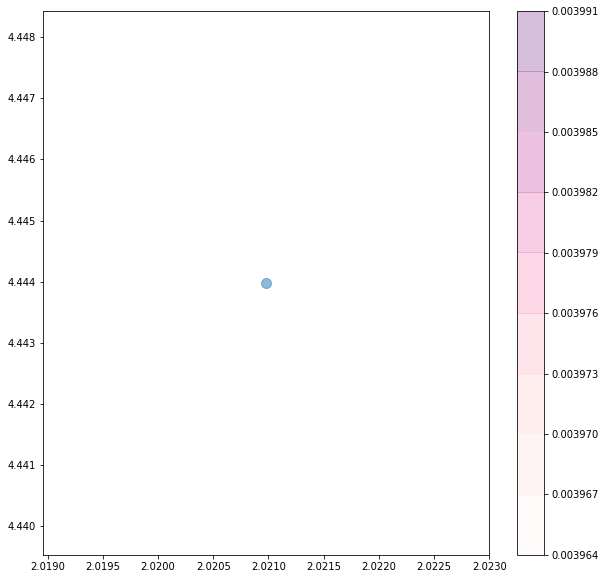

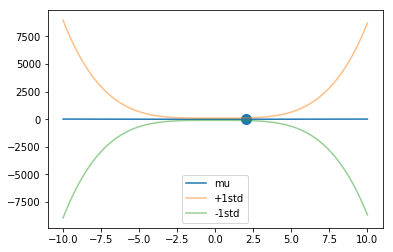

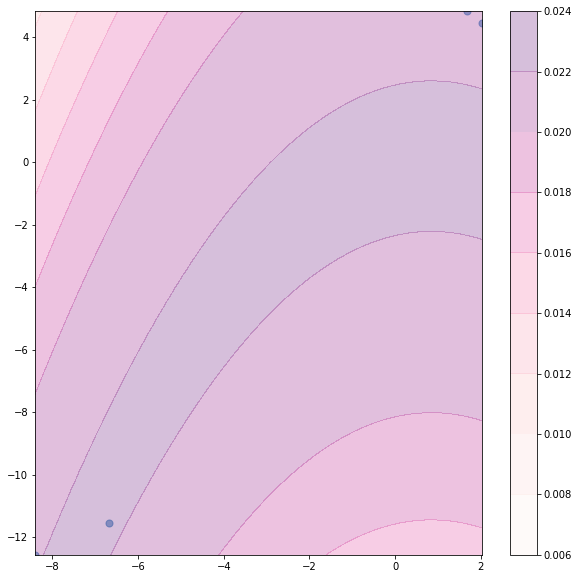

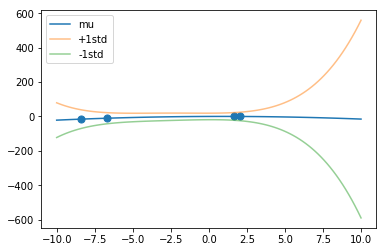

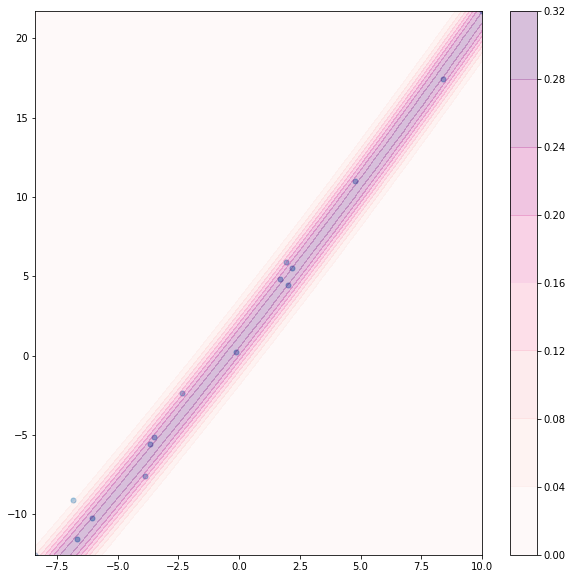

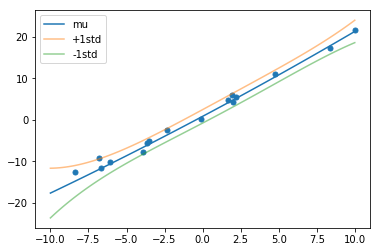

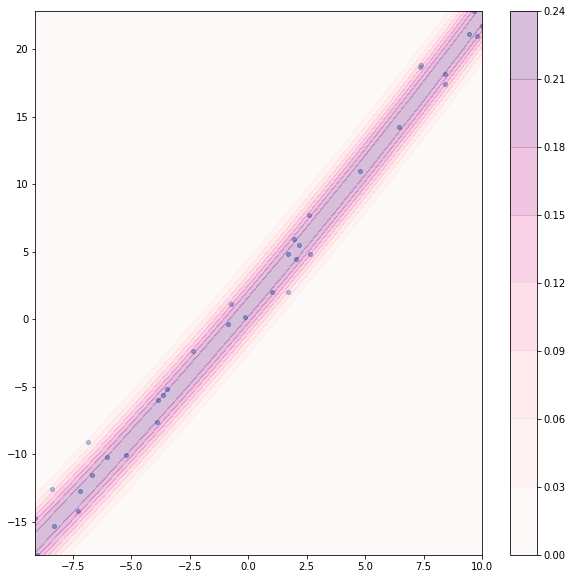

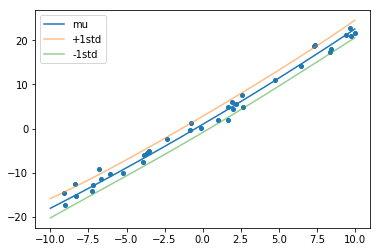

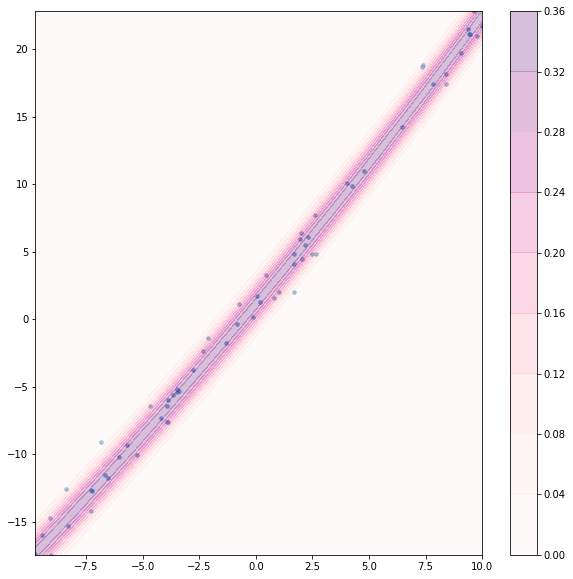

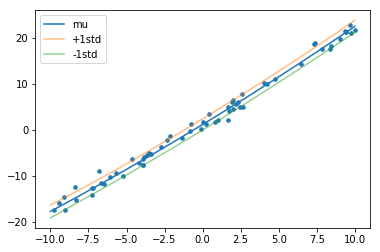

[[5.93414267]] 0.0010190482051782783
[[0.00021728]] 0.0010394207155041268
Converge after 1000 iter


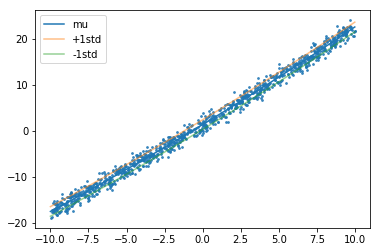

In [44]:
# Ground Truth  y = x^2
w_gt = [1.5, 2, 0.01]
num_basis = len(w_gt)
w_gt = np.array(w_gt, ndmin=2).reshape(num_basis, 1)
data_var = 1

# prior 
a = 0.01         # a: guess 1/var of y
b = 1              # b: guess 1/var of weight

mu_prior = np.array( [[0.0 for x in range(num_basis)] ] ).T
lambda_prior = np.identity(num_basis) * b

mu_last = mu_prior

points_xs = []
points_ys = []
diffs = []

max_data_points = 10000
batch_size = 500
for i in range(1, max_data_points+1):
    
    # Generate data points 
    x = np.asscalar(np.random.uniform(-10,10,1))
    phi = x2phi(x, num_basis)
    y = phi2y(phi, w_gt) + noise(data_var)
    points_xs.append(x)
    points_ys.append(np.asscalar(y))
    
    # MAP
    mu_posterior, lambda_posterior = max_posterior(phi, y, a, mu_prior, lambda_prior)
    
    # Update prior
    mu_prior = mu_posterior
    lambda_prior = lambda_posterior
    
    # Update a (guess 1/var of y)
    if i > 2:
        a = est_a(points_xs, points_ys, mu_posterior)
    if i % batch_size == 0:
        var = 1/a
        threshold = 0.001 * var
        diff = np.matmul( (mu_last-mu_posterior).T, (mu_last-mu_posterior))
        print(diff, threshold)
        if diff < threshold:
            print('Converge after %d iter'%i)
            break
        mu_last = mu_posterior
        
    # Plot
    if (int(math.sqrt(i))**2==i and i%2==0 and i<10**2) or i == 1:
        plot_contour()
        plot_pred(mu_posterior, phi, a, lambda_posterior)
plot_pred(mu_posterior, phi, a, lambda_posterior)
# plot_scatter()

#prior distribution


In [34]:
print_comparsion(w_gt=w_gt, var_gt=data_var, w_pred=mu_posterior, var_pred=1/a, precision=3)

----------------------------------------------------
             |   w0   |   w1   |   w2   | variance |
----------------------------------------------------
Ground Truth |  1.500 |  2.000 |  0.010 |  1.000   |
----------------------------------------------------
  Prediction |  1.444 |  2.004 |  0.010 |  1.086   |
----------------------------------------------------


In [35]:
print_comparsion_sym(w_gt=w_gt, var_gt=data_var, w_pred=mu_posterior, var_pred=1/a, precision=8)

Ground Truth


Prediction


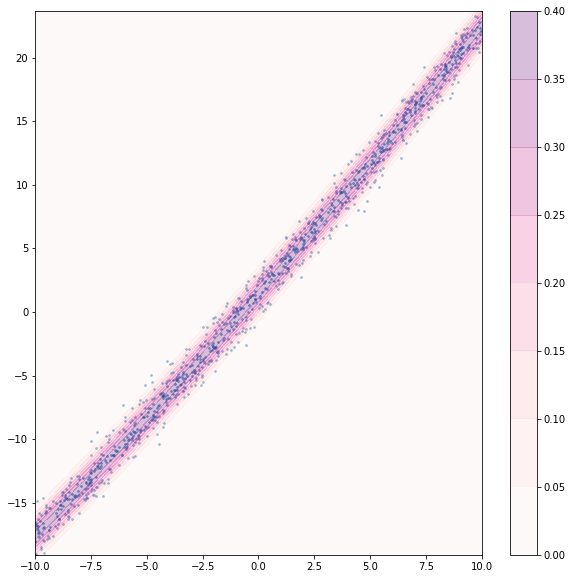

In [43]:
import scipy.stats as stats
from matplotlib import ticker, cm

def plot_pred_(mu_posterior, phi, a, lambda_posterior):
    mu_pred, var_pred = pred_distribution(mu_posterior, phi, a, lambda_posterior)
    xs = np.linspace(-10, 10, 100)
    ys_mu = []
    ys_std_up = []
    ys_std_down = []
    for x in xs:
        phi = x2phi(x, num_basis)
        mu_pred, var_pred = pred_distribution(mu_posterior, phi, a, lambda_posterior)
        ys_mu.append(mu_pred)
        ys_std_up.append(mu_pred+var_pred)
        ys_std_down.append(mu_pred-var_pred)
    plt.scatter(points_xs, points_ys, s=100*1/math.sqrt(len(points_xs)), alpha=0.5)
#     plt.plot(xs, ys_mu, label='mu')
#     plt.plot(xs, ys_std_up, alpha=1, label='+1std')
#     plt.plot(xs, ys_std_down, alpha=1, label='-1std')
#     plt.legend(loc='best')
    # plt.show()

def f(x, y, points_xs, points_ys, n):
    # the height function
    z = np.zeros((n,n))
    for x_, y_ in zip(points_xs, points_ys):
        x_ = int((x_-min(points_xs))/(max(points_xs)-min(points_xs))*n-1) 
        y_ = int((y_-min(points_ys))/(max(points_ys)-min(points_ys))*n-1) 
        z[y_][x_] += 1
    return z

def f2(x, y, n):
    z = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            phi = x2phi(x[i][j], num_basis)
            y_ = phi2y(phi, mu_posterior)
            z[i][j] = stats.norm.pdf(y[i][j], y_, (1/a))
    return z

def plot_contour():
    n = 100
    x = np.linspace(-10, 10, n)
    y = np.linspace(min(points_ys), max(points_ys), n)
    X,Y = np.meshgrid(x, y)
    XY =  np.c_[X.ravel(),Y.ravel()] # 攤平
    plt.figure(figsize=(10,10))
    plot_pred_(mu_posterior, phi, a, lambda_posterior)
    #plt.contourf(X, Y, f(X, Y, points_xs, points_ys, n), 8,  cmap='PuBu')
    plt.contourf(X, Y, f2(X, Y,n ), 8,  cmap='RdPu', alpha=0.25)
    plt.colorbar()
    plt.xlim(min(points_xs), max(points_xs))
    plt.ylim(min(points_ys), max(points_ys))
    plt.show()
    
plot_contour()
